# A predictive approach to estimate the maximum voluntary activation of the shoulder muscles

Romain Martinez<sup>*a</sup>, Jonathan Tremblay<sup>a</sup>, Mickael Begon<sup>a</sup>, Fabien Dal Maso<sup>a</sup>

<sup>a</sup>School of Kinesiology and Exercise Science, Faculty of Medicine, University of Montreal

[GitHub repo](https://github.com/romainmartinez/mvc)

# Part 1: Getting the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio

# to make this notebook's output stable across runs
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

In [2]:
PROJECT_PATH = Path("./")
DATA_PATH = PROJECT_PATH / "data"
MODEL_PATH = PROJECT_PATH / "model"

## Read the data

We start this notebook with data in matlab format, where each file corresponds to different experiments.

Each file contains a 3-dimensional matrix where the first dimension corresponds to the _participant_, the second to the _tested muscle_ and the third to the _test performed_.

![Maximum voluntary isometric contraction tests performed.](./share/fig/positions.svg)

In [3]:
mat = {}
data = {key: [] for key in ("dataset", "participant", "muscle", "test", "mvc")}
dataset_names = []
count = -1


for ifile in DATA_PATH.glob("*only_max.mat"):
    # dataset name
    dataset = ifile.stem.replace("_only_max", "").replace("MVE_Data_", "")
    dataset_names.append(dataset)

    # data
    mat[dataset] = sio.loadmat(ifile)["MVE"]
    print(f"project {dataset}: {mat[dataset].shape[0]} participants")

    for iparticipant in range(mat[dataset].shape[0]):
        count += 1
        for imuscle in range(mat[dataset].shape[1]):
            for itest in range(mat[dataset].shape[2]):
                data["participant"].append(count)
                data["dataset"].append(dataset)
                data["muscle"].append(imuscle)
                data["test"].append(itest)
                data["mvc"].append(mat[dataset][iparticipant, imuscle, itest])

project Romain2017: 32 participants
project Landry2015_1: 14 participants
project Landry2016: 15 participants
project Violon: 10 participants
project Tennis: 16 participants
project Yoann_2015: 22 participants
project Landry2015_2: 11 participants
project Landry2012: 18 participants
project Patrick_2013: 16 participants
project Sylvain_2015: 10 participants
project Landry2013: 21 participants


## Transform the data

In [4]:
df_tidy = pd.DataFrame(data).dropna()
df_tidy["test"] = df_tidy["test"].apply(lambda x: f"test {str(x + 1).zfill(2)}")

MUSCLES = [
    "upper trapezius",
    "middle trapezius",
    "lower trapezius",
    "anterior deltoid",
    "middle deltoid",
    "posterior deltoid",
    "pectoralis major",
    "serratus anterior",
    "latissimus dorsi",
    "supraspinatus",
    "infraspinatus",
    "subscapularis",
]


df_tidy["muscle"] = np.array(MUSCLES)[df_tidy["muscle"]]

print(f"dataset shape = {df_tidy.shape}")
df_tidy.head()

dataset shape = (18465, 5)


,dataset,participant,muscle,test,mvc
0,Romain2017,0,upper trapezius,test 01,0.000381
3,Romain2017,0,upper trapezius,test 04,0.000300
4,Romain2017,0,upper trapezius,test 05,0.000348
5,Romain2017,0,upper trapezius,test 06,0.000111
8,Romain2017,0,upper trapezius,test 09,0.000249


In [5]:
df_wide = df_tidy.pivot_table(
    index=["dataset", "participant", "muscle"],
    columns="test",
    values="mvc",
    fill_value=np.nan,
).reset_index()
df_wide.head()

test,dataset,participant,muscle,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15,test 16
0,Landry2012,120,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Landry2012,120,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Landry2012,120,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Landry2012,120,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Landry2012,120,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2: Data exploration

In [6]:
df_wide['participant'].nunique()

185

In [7]:
import altair as alt
from altair import datum
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Muscles and tests count

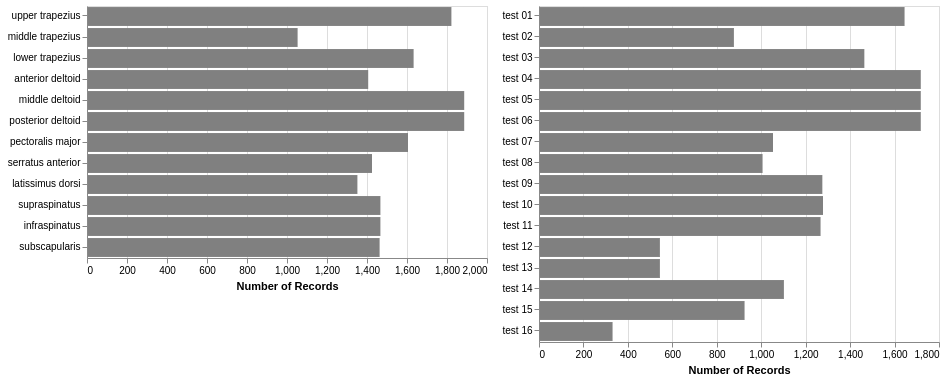

In [8]:
base = alt.Chart(df_tidy).encode(x="count()")
muscle = base.mark_bar(color='grey').encode(alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None))
test = base.mark_bar(color='grey').encode(alt.Y("test", title=None))
(muscle | test)#.properties(title="Number of records by muscle & test")

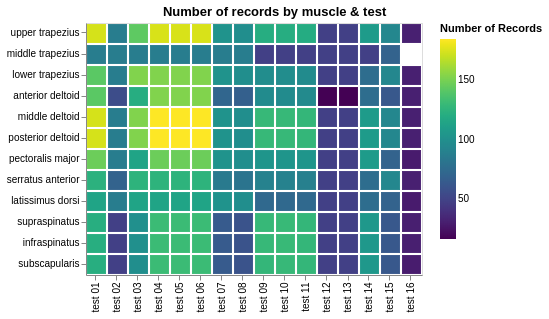

In [9]:
alt.Chart(df_tidy).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    color="count()",
).properties(title="Number of records by muscle & test")

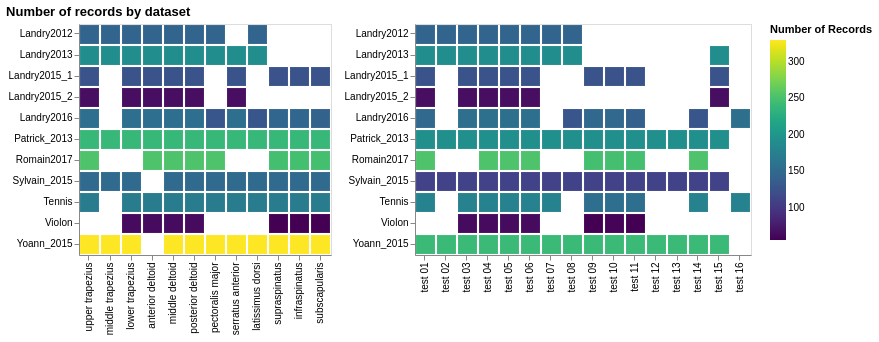

In [10]:
base = alt.Chart(df_tidy).encode(alt.Y("dataset", title=None), color="count()")
test = base.mark_rect().encode(alt.X("test", title=None))
muscle = base.mark_rect().encode(alt.X("muscle", sort=alt.Sort(MUSCLES), title=None))
(muscle | test).properties(title="Number of records by dataset")

## NaNs count

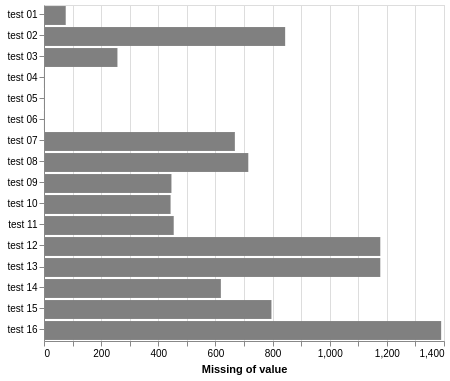

In [11]:
alt.Chart(df_wide.melt(id_vars=["dataset", "participant", "muscle"])).mark_bar(color='grey').encode(
    alt.X("missing(value)"), alt.Y("test", title=None)
)

## Which test normalizes which muscle

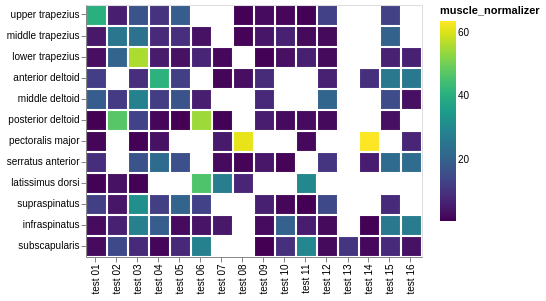

In [12]:
dff = df_tidy.groupby(["test", "muscle"])["mvc"].count().rename("count").to_frame()

max_test = (
    df_tidy.groupby(["participant", "muscle"], as_index=False)
    .apply(lambda x: x["test"][x["mvc"].idxmax()])
    .rename("test")
    .reset_index()
)

dff = dff.merge(
    max_test.groupby(["muscle", "test"]).count().reset_index(), on=["muscle", "test"]
).rename(columns={"participant": "max_test"})


dff["muscle_normalizer"] = dff["max_test"] / dff["count"] * 100

alt.Chart(dff).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    alt.Color("muscle_normalizer"),
)

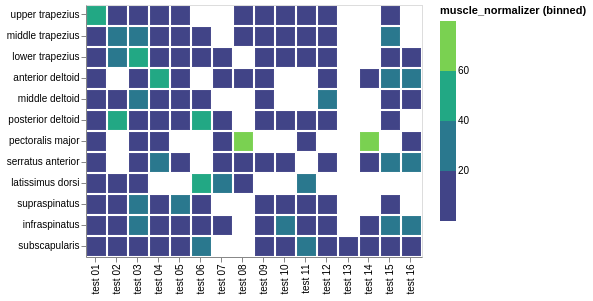

In [13]:
alt.Chart(dff).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    alt.Color("muscle_normalizer", bin=True),
)

# Part 3: Machine learning pipeline

Since tests number 4, 5 and 6 have few missing data (3) and are good normalizers, we will try to predict the maximum obtained with the 16 tests from these three tests alone.

## Normalization

In [14]:
# class Normalize:
#     def __init__(self, ref):
#         self.ref = ref

#     def fit(self, X, y=None):
#         self.ref_vector = X[self.ref]
#         return self

#     def transform(self, X):
#         return X.multiply(100, axis=0).divide(self.ref_vector, axis=0)

#     def fit_transform(self, X, y=None):
#         return self.fit(X).transform(X)

#     def inverse_transform(self, X):
#         return X.divide(100, axis=0).multiply(self.ref_vector, axis=0)

## Split the data

In [15]:
# from sklearn.model_selection import GroupShuffleSplit


# class Pipeline:
#     def __init__(self):
#         pass
    
#     def get_X_and_y(self, d, cols):
#         X = d[cols].dropna(subset=cols)
#         y = d.loc[X.index].select_dtypes(include="float").max(axis=1)
#         p = d["participant"].loc[X.index]

#         # remove the top 2.5 percentile
#         normalized_y = Normalize(ref="test 05").fit(X).transform(y)
#         y = y.loc[normalized_y < normalized_y.quantile(0.975)]
#         return X.loc[y.index], y, p.loc[y.index]

#     @staticmethod
#     def drop_na_rows(d, cols):
#         c = [i for i in cols if i != "muscle"]
#         original_shape = d.shape
#         d = d.dropna(how="all", subset=c)
#         deleted_rows = original_shape[0] - d.shape[0]
#         if deleted_rows != 0:
#             print(f'drop {deleted_rows} NaN rows')
#         return d

#     @staticmethod
#     def split_data(X, y, p, test_size):
#         # we want to make sure that all the data from one participant is in only one set
#         train_id, test_id = next(
#             GroupShuffleSplit(test_size=test_size, random_state=RANDOM_SEED).split(
#                 X, groups=p
#             )
#         )
#         return X.iloc[train_id], X.iloc[test_id], y.iloc[train_id], y.iloc[test_id]


## Evaluation

In [16]:
# from sklearn.metrics import r2_score


# class Evaluate:
#     def __init__(self):
#         pass

#     @staticmethod
#     def mape_vector(y_true, y_pred):
#         return (np.abs((y_true - y_pred) / y_true)) * 100

#     def mape(self, y_true, y_pred):
#         return self.mape_vector(y_true, y_pred).mean()

#     @staticmethod
#     def rmse(y_true, y_pred):
#         val = np.sqrt(((y_pred - y_true) ** 2).mean())
#         return val

#     def report(self, y_true, y_pred):
#         d = {
#             "rmse": self.rmse(y_true, y_pred),
#             "mape": self.mape(y_true, y_pred),
#             "r2": r2_score(y_true, y_pred),
#         }
#         return d


In [17]:
# from xgboost import XGBRegressor
# # from sklearn.linear_model import LinearRegression

# COLS_TO_KEEP = ["test 04", "test 05", "test 06"]
# TEST_SIZE = 0.2
# base_params = {"n_jobs": 1, "silent": True, "random_state": RANDOM_SEED}
# results = {"train": {}, "test": {}}
# index, model, mape_vector = {}, {}, {}

# for imuscle in MUSCLES:
#     subset = df_wide[df_wide["muscle"] == imuscle]
#     pipe = Pipeline()
#     X, y, participants = pipe.get_X_and_y(d=subset, cols=COLS_TO_KEEP)
#     X_train, X_test, y_train, y_test = pipe.split_data(
#         X, y, participants, test_size=0.2
#     )

#     index[imuscle] = {"train": y_train.index, "test": y_test.index}

#     norm_train = Normalize(ref="test 05").fit(X_train)
#     X_train, y_train = (norm_train.transform(X_train), norm_train.transform(y_train))

#     norm_test = Normalize(ref="test 05").fit(X_test)
#     X_test, y_test = norm_test.transform(X_test), norm_test.transform(y_test)

#     fit_params = {
#         "eval_set": [(X_train, y_train), (X_test, y_test)],
#         "early_stopping_rounds": 50,
#         "eval_metric": "rmse",
#         "verbose": None,
#     }

#     model = XGBRegressor(**base_params)
#     model.fit(X_train, y_train, **fit_params)
# #     model = LinearRegression()
# #     model.fit(X_train, y_train)

#     y_pred_train, y_pred_test = (model.predict(X_train), model.predict(X_test))
#     results["train"][imuscle] = Evaluate().report(y_train, y_pred_train)
#     results["test"][imuscle] = Evaluate().report(y_test, y_pred_test)
#     mape_vector[imuscle] = Evaluate().mape_vector(y_test, y_pred_test)

In [18]:
# r = pd.DataFrame()
# for isplit in ["train", "test"]:
#     s = pd.DataFrame(results[isplit]).T.rename_axis("muscle").reset_index()
#     s["split"] = isplit
#     r = pd.concat([r, s])
# print(f"mean for all muscles:\n{r.mean()}")

In [19]:
# alt.Chart(r).mark_bar().encode(
#     alt.X("split", axis=alt.Axis(title="", labels=False, ticks=False, domain=False)),
#     alt.Y("mape"),
#     alt.Color("split"),
#     alt.Column("muscle", sort=MUSCLES, title=None),
# ).properties(width=70)

---

In [20]:
from sklearn.model_selection import GroupShuffleSplit

class Normalize:
    def __init__(self, ref):
        self.ref = ref

    def fit(self, X, y=None):
        self.ref_vector = X[self.ref]
        return self

    def transform(self, X):
        if isinstance(X, pd.core.series.Series):
            return X.multiply(100, axis=0).divide(self.ref_vector, axis=0)
        else:
            X = X.copy()
            num_cols = X.select_dtypes(include="float").columns
            X[num_cols] = (
                X[num_cols].multiply(100, axis=0).divide(self.ref_vector, axis=0)
            )
            return X

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        return X.divide(100, axis=0).multiply(self.ref_vector, axis=0)


def get_X_y_p(d, cols):
    X = d[cols].dropna(subset=cols)
    y = d.select_dtypes(include="float").max(axis=1)
    p = d["participant"].iloc[X.index]

    # remove the top 2.5 percentile
    normalized_y = Normalize(ref="test 05").fit(X).transform(y)
    y = y.loc[normalized_y < normalized_y.quantile(0.975)]
    return X.loc[y.index], y, p.loc[y.index]


def split_data(X, y, p, test_size):
    # we want to make sure that all the data from one participant is in only one set
    train_id, test_id = next(
        GroupShuffleSplit(test_size=test_size, random_state=RANDOM_SEED).split(
            X, groups=p
        )
    )
    return X.iloc[train_id], X.iloc[test_id], y.iloc[train_id], y.iloc[test_id]


def mape_vector(y_true, y_pred):
    return (np.abs((y_pred - y_true) / y_true))


In [21]:
COLS_TO_KEEP = ["muscle", "test 04", "test 05", "test 06"]
TEST_SIZE = 0.2

X, y, p = get_X_y_p(df_wide, COLS_TO_KEEP)

X_train, X_test, y_train, y_test = split_data(X, y, p, test_size=0.2)

float_cols = X.select_dtypes(include="float").columns

norm_train = Normalize(ref="test 05").fit(X_train)
X_train = norm_train.transform(X_train)
y_train = norm_train.transform(y_train)

norm_test = Normalize(ref="test 05").fit(X_test)
X_test = norm_test.transform(X_test)
y_test = norm_test.transform(y_test)

In [22]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=False, random_seed=RANDOM_SEED)
model.fit(X_train, y_train, cat_features=[0])

In [23]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [24]:
train_eval = (
    mape_vector(y_train, y_pred_train)
    .rename("mape")
    .to_frame()
    .assign(muscle=X_train["muscle"], split="train")
)
test_eval = (
    mape_vector(y_test, y_pred_test)
    .rename("mape")
    .to_frame()
    .assign(muscle=X_test["muscle"], split="test")
)

eval_df = pd.concat([train_eval, test_eval])
eval_df.head()

,mape,muscle,split
0,0.108509,anterior deltoid,train
1,0.016882,latissimus dorsi,train
2,0.091399,lower trapezius,train
3,0.205286,middle deltoid,train
4,0.355257,middle trapezius,train


In [25]:
eval_df.query('split == "test"').mean()

mape    0.195016
dtype: float64

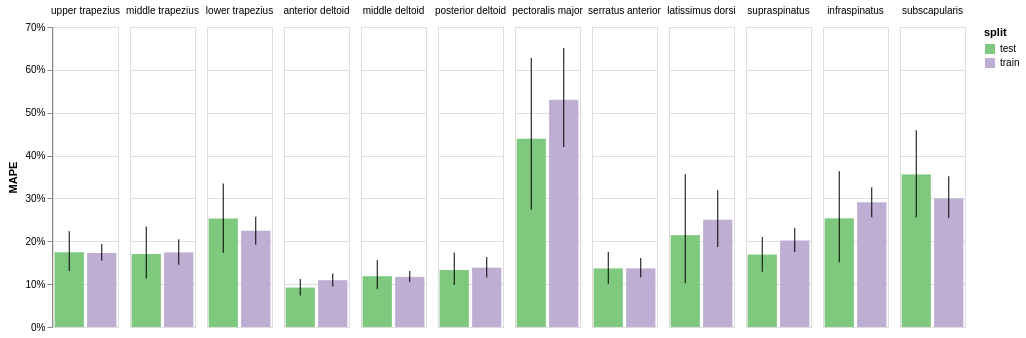

In [26]:
base = (
    alt.Chart()
    .encode(
        alt.X(
            "split",
            title=None,
            axis=alt.Axis(labels=False, domain=False, ticks=False),
            sort=["train", "test"],
        )
    )
    .properties(width=65)
)

bar = base.mark_bar().encode(
    alt.Y("mean(mape)", title="MAPE", axis=alt.Axis(format="%")), alt.Color("split", scale=alt.Scale(scheme='accent'))
)
error = base.mark_rule().encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))


(bar + error).facet(data=eval_df, column=alt.Column("muscle", sort=MUSCLES, title=None))

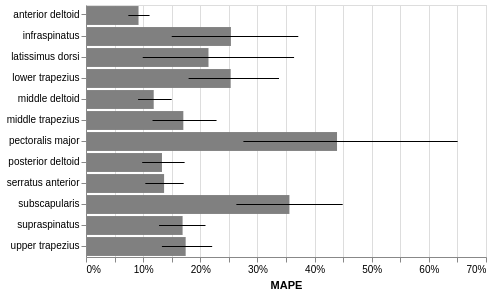

In [27]:
base = alt.Chart(test_eval).encode(alt.Y("muscle", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
error = base.mark_rule().encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

bar + error

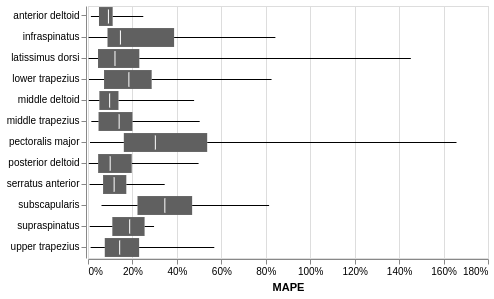

In [28]:
base = alt.Chart().encode(alt.Y("muscle", sort=MUSCLES, title=None))

bar = base.mark_bar(color="#606060").encode(
    alt.X("q1(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.X2("q3(mape)")
)
lower = base.mark_rule().encode(alt.X("min(mape)"), alt.X2("q1(mape)"))
upper = base.mark_rule().encode(alt.X("q3(mape)"), alt.X2("max(mape)"))
med = base.mark_tick(color='white').encode(alt.X("median(mape)"))

(upper + bar + med + lower).facet(data=test_eval)

In [29]:
mean_error = test_eval["mape"].mean()

error_vector = pd.DataFrame({"emg": np.linspace(0, 1, 100)}).assign(
    error=lambda x: x["emg"] * mean_error,
    error_upper=lambda x: x["emg"] + x["emg"] * mean_error,
    error_lower=lambda x: x["emg"] - x["emg"] * mean_error,
)

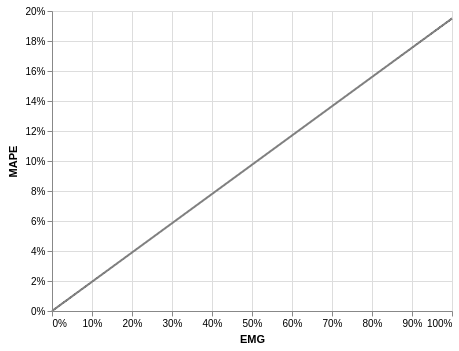

In [30]:
alt.Chart(error_vector).mark_line(color="grey").encode(
    alt.X("emg", axis=alt.Axis(format="%"), title='EMG'),
    alt.Y("error", title="MAPE", axis=alt.Axis(format="%")),
)

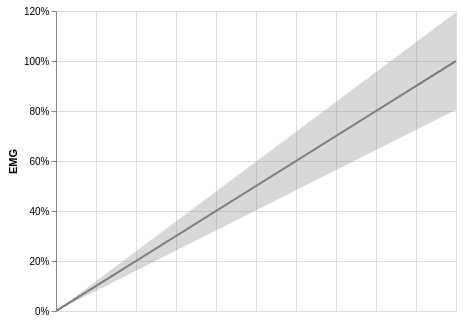

In [31]:
line = (
    alt.Chart(error_vector)
    .mark_line(color="grey")
    .encode(
        alt.X(
            "emg", title=None, axis=alt.Axis(labels=False, domain=False, ticks=False)
        ),
        alt.Y("emg", title="EMG", axis=alt.Axis(format="%")),
    )
)
area = (
    alt.Chart(error_vector)
    .mark_area(color="grey", opacity=0.3)
    .encode(alt.X("emg"), alt.Y("error_lower"), alt.Y2("error_upper"))
)
line + area

In [32]:
import pymc3 as pm

In [33]:
from scipy.stats import gaussian_kde


def min_max_scaler(x, pad):
    x_min = x.min() + x.min() * pad if pad else x.min()
    x_max = x.max() + x.max() * pad if pad else x.max()
    return (x - x_min) / (x_max - x_min)


def compute_kde(x, n_points=100, pad=0.1, mini=None, maxi=None, normalize=True):
    x = x.dropna().copy()
    x_min = mini if mini else x.min() - x.min() * pad
    x_max = maxi if maxi else x.max() + x.max() * pad
    x_grid = np.linspace(x_min, x_max, n_points)

    if normalize:
        kde = min_max_scaler(gaussian_kde(x)(x_grid), pad=0.2)
    else:
        gaussian_kde(x)(x_grid)

    return pd.DataFrame({"value": x_grid, "kde": kde})

In [34]:
def bayes_summary(trace, ref, alpha=0.05):
    d = (
        pm.trace_to_dataframe(trace)
        if isinstance(trace, pm.backends.base.MultiTrace)
        else trace
    )
    return (
        pd.DataFrame(
            {
                "mean": d.mean(),
                "std_lower": d.mean() - d.std(),
                "std_upper": d.mean() + d.std(),
                f"proba < {ref}": (d < ref).sum() / d.notnull().sum() * 100,
                f"proba > {ref}": (d > ref).sum() / d.notnull().sum() * 100,
            }
        )
        .join(
            pd.DataFrame(
                [pm.hpd(d[i].dropna(), alpha=alpha) for i in d],
                columns=["hpd_lower", "hpd_upper"],
                index=d.columns,
            )
        )
        .assign(
            **{
                f"{ref} outside HPD": lambda x: (x.filter(like="hpd") > ref).all(axis=1)
                | (x.filter(like="hpd") < ref).all(axis=1)
            }
        )
    )

In [35]:
def plot_bayes_violin(trace, ref, domain, xlabel, alpha=0.05, height=None):
    # get summary and assign y coordinates
    summary = (
        bayes_summary(trace, ref, alpha)
        .assign(y_plot=lambda x: np.arange(0, x.shape[0], 1))
        .reset_index()
    )

    # compute kde
    kdes = (
        pd.concat(
            [
                compute_kde(
                    trace[i].dropna().reset_index(drop=True), n_points=500, pad=0.1
                ).assign(index=i)
                for i in trace
            ]
        )
        .merge(summary[["index", "y_plot", f"{ref} outside HPD"]], on="index")
        .assign(kde=lambda x: x["kde"] + x["y_plot"])
    )

    # make chart
    color_scale = alt.Scale(domain=[True, False], range=["#252525", "#737373"])
    base = alt.Chart().encode(
        alt.Y("y_plot"),
        alt.Color(f"{ref} outside HPD", scale=color_scale),
        alt.Tooltip(["index:N", "mean:Q", "hpd_lower:Q", "hpd_upper:Q"]),
    )

    points = base.mark_circle(size=200).encode(
        alt.X("mean", title=xlabel, axis=alt.Axis(format="%"))
    )

    rules_hpd = base.mark_rule(size=4).encode(
        alt.X("hpd_lower", scale=alt.Scale(domain=domain, clamp=True)),
        alt.X2("hpd_upper"),
    )

    rule = (
        alt.Chart(pd.DataFrame({"ref": ref}, index=[0]))
        .mark_rule(color="grey", strokeWidth=2)
        .encode(alt.X("ref"))
    )

    y_labels = (
        alt.Chart()
        .mark_text(dx=-205, align="right")
        .encode(alt.Y("y_plot"), alt.Text("index"))
    )

    k = (
        alt.Chart(kdes)
        .mark_area(opacity=0.7, clip=True)
        .encode(
            alt.X("value", scale=alt.Scale(domain=domain, clamp=True)),
            alt.Y(
                "kde",
                axis=alt.Axis(labels=False, ticks=False, domain=False, grid=False),
                scale=alt.Scale(domain=[0, summary.shape[0]]),
                title=None,
            ),
            alt.Y2("y_plot"),
            alt.Detail("index"),
            alt.Color(f"{ref} outside HPD", scale=color_scale),
        )
    )
    rule = rule.properties(height=height) if height else rule
    return (rule + rules_hpd + points + k + y_labels).facet(data=summary)

In [36]:
x = (
    test_eval.drop("split", axis=1)
    .rename(columns={'muscle': 'index'})
    .pivot(columns="index")
    .droplevel(level=0, axis=1)
)[MUSCLES]
x.head()

index,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,infraspinatus,subscapularis
8,NaN,NaN,NaN,0.058858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097979,NaN,NaN,NaN
10,NaN,NaN,0.248953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,0.00357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,0.434778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
bayes_summary(x, ref=0.1)

,mean,std_lower,std_upper,proba < 0.1,proba > 0.1,hpd_lower,hpd_upper,0.1 outside HPD
index,,,,,,,,
upper trapezius,0.174401,0.035276,0.313526,40.000000,60.000000,0.011756,0.462883,False
middle trapezius,0.170318,0.022404,0.318231,39.130435,60.869565,0.015048,0.460624,False
lower trapezius,0.253177,0.010533,0.495821,30.303030,69.696970,0.004424,0.762947,False
anterior deltoid,0.091919,0.037173,0.146665,64.516129,35.483871,0.013119,0.196753,False
middle deltoid,0.118483,0.014633,0.222333,51.351351,48.648649,0.003570,0.343820,False
posterior deltoid,0.132933,0.018629,0.247236,51.351351,48.648649,0.003681,0.389161,False
pectoralis major,0.439285,0.003858,0.874711,13.636364,86.363636,0.009014,1.518838,False
serratus anterior,0.136651,0.040023,0.233279,44.000000,56.000000,0.007066,0.304492,False
latissimus dorsi,0.214338,-0.128626,0.557301,48.000000,52.000000,0.002636,1.125259,False


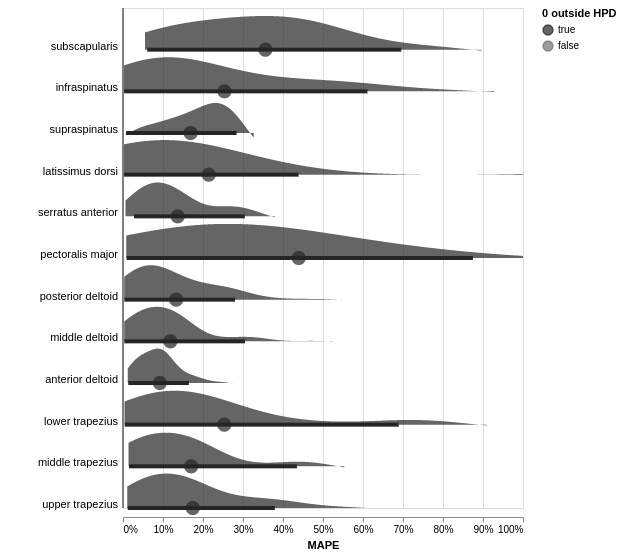

In [38]:
plot_bayes_violin(x, ref=0, domain=[0, 1], xlabel="MAPE", alpha=0.1, height=500)

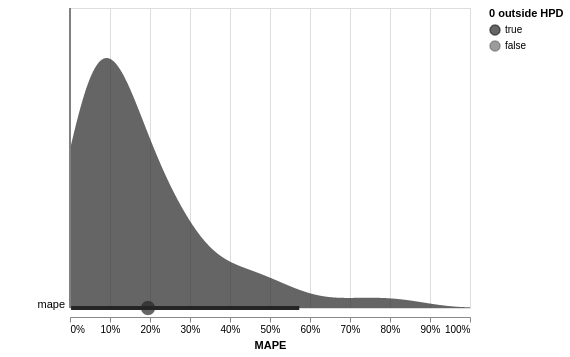

In [39]:
plot_bayes_violin(test_eval[['mape']], ref=0, domain=[0, 1], xlabel='MAPE')

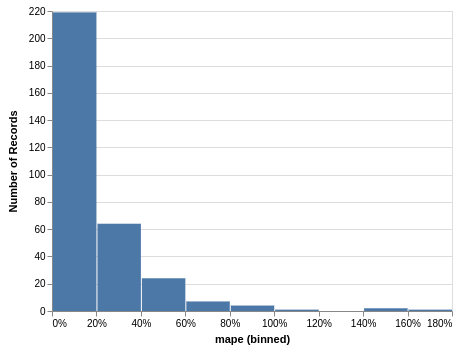

In [40]:
alt.Chart(test_eval).mark_bar().encode(
    alt.Y("count()"),
    alt.X("mape", bin=alt.Bin(maxbins=10), axis=alt.Axis(format="%")),
#     alt.Row("muscle"),
)

# Part 4: Comparison with other studies

In [41]:
import pickle

RECOMMANDATIONS_PATH = MODEL_PATH / "recommandations.pkl"
if RECOMMANDATIONS_PATH.is_file():
    with open(RECOMMANDATIONS_PATH, "rb") as h:
        recommandations = pickle.load(h)
else:
    recommandations = {}

## Boettcher et al., 2008

[Boettcher et al., 2008](https://onlinelibrary.wiley.com/doi/abs/10.1002/jor.20675) identified a unique combinations of 4 MVIC tests to normalize 12 shoulder muscles

In [42]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["NT4"] = {
        i: ["test 12", "test 13", "test 14", "test 15"] for i in MUSCLES
    }

## Dal Maso et al., 2016

[Dal Maso et al., 2016](https://www.sciencedirect.com/science/article/pii/S0003999316000307)

### As published

In [43]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["DM"] = {
        "upper trapezius": ["test 01", "test 03", "test 05", "test 12"],
        "middle trapezius": [
            "test 02",
            "test 03",
            "test 08",
            "test 10",
            "test 12",
            "test 15",
        ],
        "lower trapezius": ["test 02", "test 03", "test 05", "test 11", "test 15"],
        "anterior deltoid": ["test 04", "test 05", "test 09", "test 12"],
        "middle deltoid": ["test 03", "test 09", "test 12", "test 15"],
        "posterior deltoid": ["test 02", "test 06"],
        "pectoralis major": ["test 08", "test 14"],
        "serratus anterior": ["test 03", "test 05", "test 07", "test 14", "test 15"],
        "latissimus dorsi": ["test 06", "test 07", "test 08", "test 11"],
        "supraspinatus": ["test 01", "test 03", "test 05", "test 12"],
        "infraspinatus": ["test 02", "test 03", "test 04", "test 15"],
        "subscapularis": [
            "test 02",
            "test 03",
            "test 06",
            "test 10",
            "test 11",
            "test 15",
        ],
    }

### Implemented on our data

In [44]:
def compute_criterion(d, sets, thr):
    proportion = np.ones((sets.shape[0]))
    for i, iset in enumerate(sets):
        maximal_above_thr = d[iset].max(axis=1) > d.max(axis=1) * (thr / 100)
        proportion[i] = maximal_above_thr.sum() / d.shape[0] * 100

    sorted_idx = np.argsort(proportion)
    best_set = sets[sorted_idx][-1]
    best_proportion = proportion[sorted_idx][-1]
    return best_set, best_proportion

In [45]:
from itertools import combinations

THRESHOLD = 90
PERCENTILE = 90
TESTS = [i for i in df_wide.columns if i[:4] == "test"]

if RECOMMANDATIONS_PATH.is_file():
    print(recommandations["DM updated"])
else:
    recommandations["DM updated"] = {}
    for imuscle in MUSCLES:
        X_train_comp = df_wide.loc[X_train.index].query("muscle == @imuscle")[TESTS]
        print(f"{imuscle.upper()} ({X_train_comp.shape[0]} points)")

        for ntests in range(1, len(TESTS) + 1):
            sets = np.array(list(combinations(TESTS, ntests)))
            best_set, best_proportion = compute_criterion(X_train_comp, sets, thr=THRESHOLD)

            if best_proportion > PERCENTILE:
                print(f"\tno. of tests: {ntests}")
                print(f"\tbest set: {best_set}")
                print(f"\tproportion: {best_proportion:.2f}")
                print("-" * 10)
                recommandations["DM updated"][imuscle] = best_set
                break
    with open(RECOMMANDATIONS_PATH, "wb") as h:
        pickle.dump(recommandations, h)

{'upper trapezius': array(['test 01', 'test 03', 'test 05'], dtype='<U7'), 'middle trapezius': array(['test 02', 'test 03', 'test 05', 'test 09', 'test 10', 'test 15'],
      dtype='<U7'), 'lower trapezius': array(['test 02', 'test 03', 'test 04', 'test 06', 'test 15'], dtype='<U7'), 'anterior deltoid': array(['test 03', 'test 04', 'test 05', 'test 09', 'test 15', 'test 16'],
      dtype='<U7'), 'middle deltoid': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'posterior deltoid': array(['test 02', 'test 03', 'test 06'], dtype='<U7'), 'pectoralis major': array(['test 08', 'test 14'], dtype='<U7'), 'serratus anterior': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'latissimus dorsi': array(['test 06', 'test 07', 'test 11'], dtype='<U7'), 'supraspinatus': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 09'], dtype='<U7'), 'infraspinatus': array(['test 03', 'test 04', 'test 06', 'test 10', 'test 11', 'test 15'],
      dt

## Compare Boettcher & Dal Maso with our model

### MAPE for each method

In [46]:
recommandations["B-4"] = recommandations.pop("NT4")
recommandations["DM-14"] = recommandations.pop("DM")
recommandations.pop('DM updated', None);

In [47]:
recommandations.keys()

dict_keys(['B-4', 'DM-14'])

In [48]:
test_comparison = df_wide.drop(["dataset", "participant"], axis=1).loc[X_test.index]

r = []
for imuscle in MUSCLES:
    current = test_comparison.query("muscle == @imuscle").drop("muscle", axis=1)
    for imethod in recommandations.keys():
        r.append(
            mape_vector(
                current.max(axis=1),
                current[recommandations[imethod][imuscle]].max(axis=1),
            )
            .rename("mape")
            .to_frame()
            .assign(method=imethod, muscle=imuscle)
        )

df_comp = pd.concat(
    r + [test_eval.drop("split", axis=1).assign(method="P-3")], sort=False
)

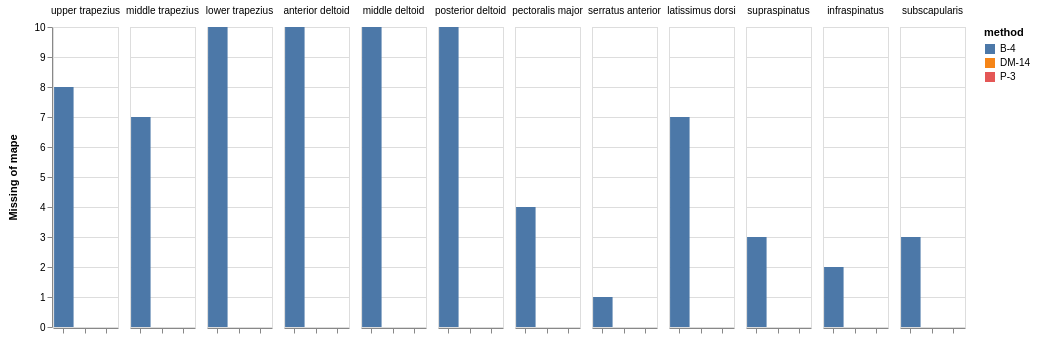

In [49]:
alt.Chart(df_comp).mark_bar().encode(
    alt.X("method", axis=alt.Axis(title="", labels=False)),
    alt.Y("missing(mape)"),
    alt.Color("method"),
    alt.Column("muscle", sort=MUSCLES, title=None),
).properties(width=65)

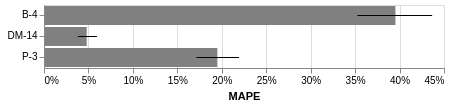

In [50]:
base = alt.Chart(df_comp).encode(alt.Y("method", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
error = base.mark_rule().encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

bar + error

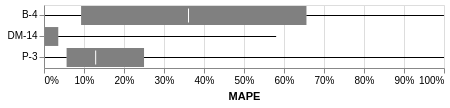

In [51]:
base = alt.Chart(df_comp).encode(alt.Y("method", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("q1(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.X2("q3(mape)")
)
med = base.mark_tick(color="white").encode(alt.X("median(mape)"))
upper = base.mark_rule().encode(
    alt.X("q3(mape)", scale=alt.Scale(domain=[0, 1], clamp=True)), alt.X2("max(mape)")
)
lower = base.mark_rule().encode(alt.X("min(mape)"), alt.X2("q1(mape)"))


bar + med + upper + lower

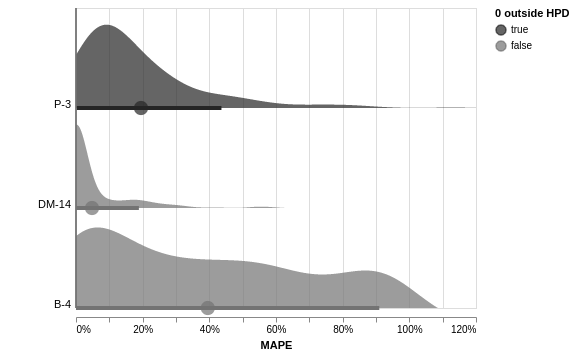

In [52]:
comp_wide = (
    df_comp.drop("muscle", axis=1)
    .rename(columns={"method": "index"})
    .pivot(columns="index")
    .droplevel(level=0, axis=1)
)

plot_bayes_violin(comp_wide, ref=0, domain=[0, 1.2], xlabel="MAPE", alpha=0.1)

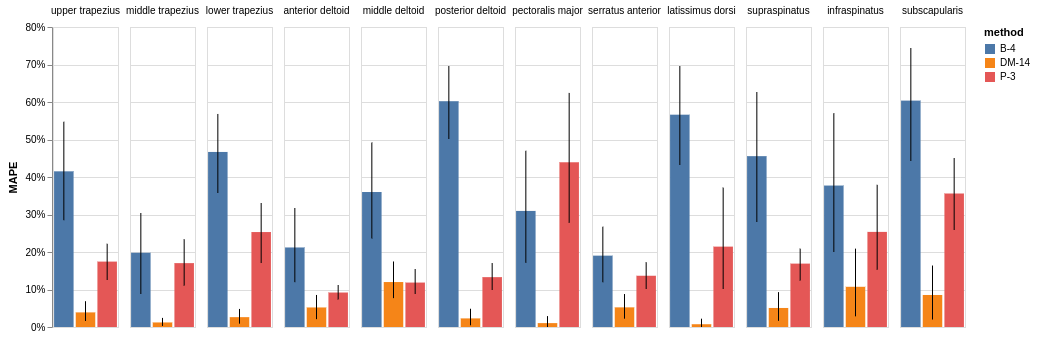

In [53]:
base = alt.Chart().encode(
    alt.X("method", axis=alt.Axis(title="", labels=False, ticks=False, domain=False))
)


bar = base.mark_bar().encode(
    alt.Y("mean(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.Color("method")
)
error = base.mark_rule().encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))

(bar.properties(width=65) + error).facet(data=df_comp, column=alt.Column("muscle", sort=MUSCLES, title=None))

### Compare execution time

In [54]:
time_by_test = 4  # min
time = {}
for imethod in recommandations.keys():
    c = []
    for imuscle, tests in recommandations[imethod].items():
        for itest in tests:
            if itest not in c:
                c.append(itest)
    time[imethod] = time_by_test * len(c)
time["P-3"] = time_by_test * 3
time = pd.Series(time).rename("Execution time (min)").rename_axis("method").reset_index()

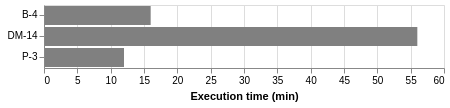

In [55]:
alt.Chart(time).mark_bar(color="grey").encode(
    alt.X("Execution time (min)"),
    alt.Y("method", title=None),
    alt.Tooltip("Execution time (min)"),
)

In [56]:
scatter_df = (
    df_comp.groupby("method")["mape"].mean().reset_index().merge(time, on="method")
).assign(
    dist_from_0=lambda x: np.sqrt(
        (x["mape"].multiply(100).pow(2) + x["Execution time (min)"].pow(2))
    ).round(2)
)

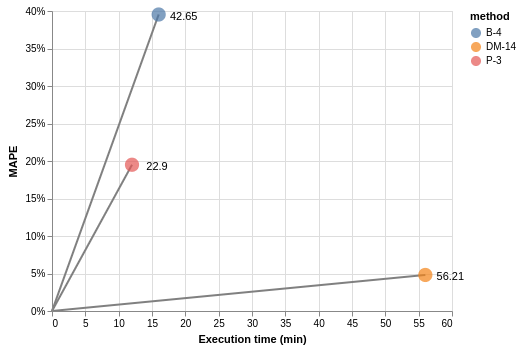

In [57]:
scatter = (
    alt.Chart(scatter_df)
    .mark_circle(size=200)
    .encode(
        alt.X("Execution time (min)", scale=alt.Scale()), alt.Y("mape", title="MAPE", axis=alt.Axis(format='%')), alt.Color("method")
    )
)

text = (
    alt.Chart(scatter_df)
    .mark_text(dx=25, dy=5)
    .encode(
        alt.X("Execution time (min)"), alt.Y("mape"), alt.Text('dist_from_0')
    )
)

dist_rule = (
    alt.Chart(
        pd.concat(
            [scatter_df, scatter_df.assign(**{"mape": 0, "Execution time (min)": 0})]
        )
    )
    .mark_line(color='grey')
    .encode(alt.X("Execution time (min)"), alt.Y("mape"), alt.Detail("method"))
)

dist_rule + scatter + text

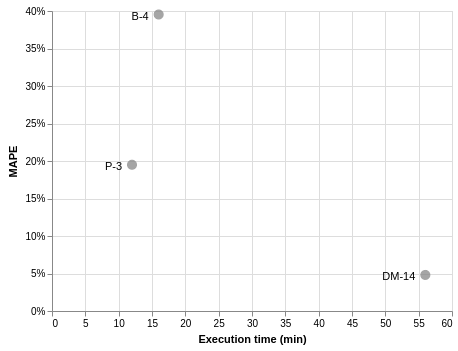

In [58]:
base = alt.Chart(scatter_df).encode(
    alt.X("Execution time (min)"),
    alt.Y("mape", title="MAPE", axis=alt.Axis(format="%")),
)

base.mark_circle(color='grey', size=100) + base.mark_text(dx=-10, dy=5, align='right').encode(alt.Text('method'))

---

### Bayes

In [59]:
import statsmodels.formula.api as smf


def glmm(data, formula, groups):
    md = smf.mixedlm(formula, data, groups=data[groups])
    mdf = md.fit()
    print(mdf.pvalues < 0.05)
    return mdf.summary()

In [69]:
formula = "mape ~ C(method) * C(muscle)"

In [70]:
glmm(data=df_comp.join(df_wide['participant']).dropna(), formula=formula, groups='participant')

Intercept                                             True
C(method)[T.DM-14]                                    True
C(method)[T.P-3]                                      True
C(muscle)[T.infraspinatus]                            True
C(muscle)[T.latissimus dorsi]                         True
C(muscle)[T.lower trapezius]                          True
C(muscle)[T.middle deltoid]                           True
C(muscle)[T.middle trapezius]                        False
C(muscle)[T.pectoralis major]                         True
C(muscle)[T.posterior deltoid]                        True
C(muscle)[T.serratus anterior]                       False
C(muscle)[T.subscapularis]                            True
C(muscle)[T.supraspinatus]                            True
C(muscle)[T.upper trapezius]                          True
C(method)[T.DM-14]:C(muscle)[T.infraspinatus]        False
C(method)[T.P-3]:C(muscle)[T.infraspinatus]          False
C(method)[T.DM-14]:C(muscle)[T.latissimus dorsi]      Tr

/home/romain/miniconda3/envs/mvc/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
============================================================================================
Model:                         MixedLM              Dependent Variable:              mape   
No. Observations:              891                  Method:                          REML   
No. Groups:                    37                   Scale:                           0.0399 
Min. group size:               14                   Likelihood:                      85.5710
Max. group size:               36                   Converged:                       Yes    
Mean group size:               24.1                                                         
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          0.195    0.045  4.317 0.000  0.106  0.283
C(method)[T.DM-14]                                -0.155    0.057 -2.734 0.006 -0.266 -0.044
C(method)[T.P-3]                                  -0.115    0.057 -2.032 0.042 -0.226 -0.004
C(muscle)[T.infraspinatus]                         0.188    0.067  2.816 0.005  0.057  0.319
C(muscle)[T.latissimus dorsi]                      0.392    0.065  6.069 0.000  0.266  0.519
C(muscle)[T.lower trapezius]                       0.282    0.061  4.657 0.000  0.163  0.401
C(muscle)[T.middle deltoid]                        0.166    0.058  2.846 0.004  0.052  0.280
C(muscle)[T.middle trapezius]                      0.038    0.067  0.564 0.573 -0.093  0.169
C(muscle)[T.pectoralis major]                      0.138    0.065  2.132 0.033  0.011  0.265
C(muscle)[T.posterior deltoid]                     0.408    0.058  7.004 0.000  0.294  0.522
C(muscle)[T.serratus anterior]                     0.006    0.060  0.095 0.924 -0.112  0.123
C(muscle)[T.subscapularis]                         0.416    0.070  5.992 0.000  0.280  0.553
C(muscle)[T.supraspinatus]                         0.266    0.067  3.990 0.000  0.136  0.397
C(muscle)[T.upper trapezius]                       0.221    0.058  3.794 0.000  0.107  0.335
C(method)[T.DM-14]:C(muscle)[T.infraspinatus]     -0.117    0.089 -1.319 0.187 -0.292  0.057
C(method)[T.P-3]:C(muscle)[T.infraspinatus]       -0.011    0.089 -0.122 0.903 -0.185  0.164
C(method)[T.DM-14]:C(muscle)[T.latissimus dorsi]  -0.408    0.084 -4.870 0.000 -0.572 -0.244
C(method)[T.P-3]:C(muscle)[T.latissimus dorsi]    -0.241    0.084 -2.875 0.004 -0.405 -0.077
C(method)[T.DM-14]:C(muscle)[T.lower trapezius]   -0.289    0.078 -3.690 0.000 -0.443 -0.136
C(method)[T.P-3]:C(muscle)[T.lower trapezius]     -0.102    0.078 -1.302 0.193 -0.256  0.052
C(method)[T.DM-14]:C(muscle)[T.middle deltoid]    -0.086    0.076 -1.131 0.258 -0.234  0.063
C(method)[T.P-3]:C(muscle)[T.middle deltoid]      -0.127    0.076 -1.675 0.094 -0.276  0.022
C(method)[T.DM-14]:C(muscle)[T.middle trapezius]  -0.039    0.086 -0.458 0.647 -0.208  0.130
C(method)[T.P-3]:C(muscle)[T.middle trapezius]     0.079    0.086  0.916 0.360 -0.090  0.248
C(method)[T.DM-14]:C(muscle)[T.pectoralis major]  -0.145    0.085 -1.709 0.087 -0.312  0.021
C(method)[T.P-3]:C(muscle)[T.pectoralis major]     0.244    0.085  2.865 0.004  0.077  0.410
C(method)[T.DM-14]:C(muscle)[T.posterior deltoid] -0.425    0.076 -5.604 0.000 -0.573 -0.276
C(method)[T.P-3]:C(muscle)[T.posterior deltoid]   -0.355    0.076 -4.678 0.000 -0.503 -0.206
C(method)[T.DM-14]:C(muscle)[T.serratus anterior]  0.015    0.080  0.192 0.848 -0.142  0.173
C(method)[T.P-3]:C(muscle)[T.serratus anterior]    0.060    0.080  0.745 0.457 -0.098  0.218
C(method)[T.DM-14]:C(muscle)[T.subscapularis]     -0.368    0.092 -4.017 0.000 -0.548 -0.189
C(method)[T.P-3]:C(muscle)[T.subscapularis]       -0.138    0.092 -1.500 

In [68]:
df_comp.head()

,mape,method,muscle
15,NaN,B-4,upper trapezius
39,NaN,B-4,upper trapezius
47,NaN,B-4,upper trapezius
55,NaN,B-4,upper trapezius
71,NaN,B-4,upper trapezius


In [200]:
SAMPLE = True
MODEL_PATH = "../models/ac_glm"

# formula = "mape ~ C(method)"

with pm.Model() as model:
    family = pm.glm.families.Normal()
    pm.glm.GLM.from_formula(
        formula,
        data=df_comp.dropna().assign(
            mape=lambda x: x.eval("(mape - mape.mean()) / mape.std()")
        ),
        family=family,
    )
model

In [199]:
with model:
    if SAMPLE:
        trace = pm.sample(100)
        pm.save_trace(trace, directory=MODEL_PATH, overwrite=True)
    else:
        trace = pm.load_trace(MODEL_PATH, model=model)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, C(method)[P-3]:C(muscle)[T.upper trapezius], C(method)[DM-14]:C(muscle)[T.upper trapezius], C(method)[B-4]:C(muscle)[T.upper trapezius], C(method)[P-3]:C(muscle)[T.supraspinatus], C(method)[DM-14]:C(muscle)[T.supraspinatus], C(method)[B-4]:C(muscle)[T.supraspinatus], C(method)[P-3]:C(muscle)[T.subscapularis], C(method)[DM-14]:C(muscle)[T.subscapularis], C(method)[B-4]:C(muscle)[T.subscapularis], C(method)[P-3]:C(muscle)[T.serratus anterior], C(method)[DM-14]:C(muscle)[T.serratus anterior], C(method)[B-4]:C(muscle)[T.serratus anterior], C(method)[P-3]:C(muscle)[T.posterior deltoid], C(method)[DM-14]:C(muscle)[T.posterior deltoid], C(method)[B-4]:C(muscle)[T.posterior deltoid], C(method)[P-3]:C(muscle)[T.pectoralis major], C(method)[DM-14]:C(muscle)[T.pectoralis major], C(method)[B-4]:C(muscle)[T.pectoralis major], C(method)[P-3]:C(m

ValueError: Not enough samples to build a trace.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52bb30c860>,
      dtype=object)

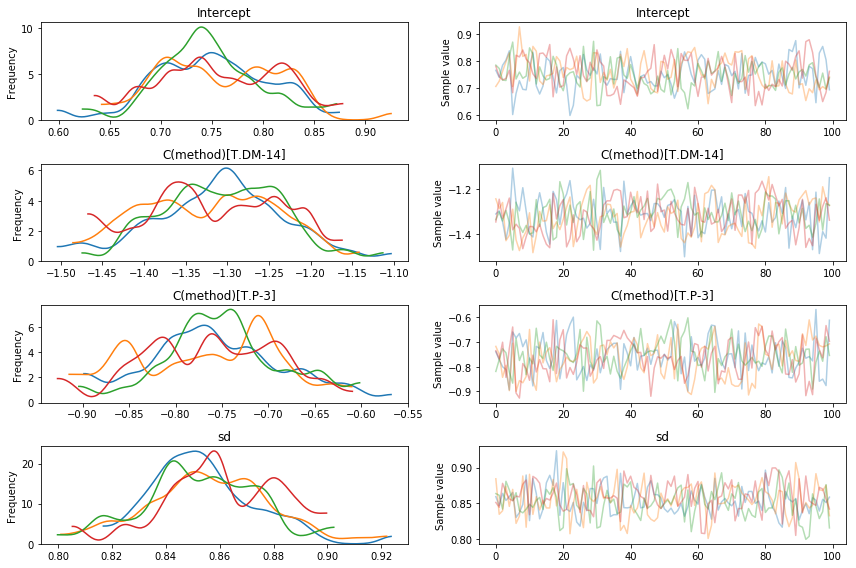

In [150]:
pm.traceplot(trace)

In [201]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

In [71]:
# y1 = df_comp.query('method == "B-4"').dropna()["mape"]
y1 = df_comp.query('method == "DM-14"').dropna()["mape"]
y2 = df_comp.query('method == "P-3"').dropna()["mape"]
y = df_comp.query('method == "B-4" | method == "P-3"').dropna()['mape']

In [72]:
μ_m = y.mean()
μ_s = y.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal("group1_mean", μ_m, sd=μ_s)
    group2_mean = pm.Normal("group2_mean", μ_m, sd=μ_s)

In [73]:
σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)

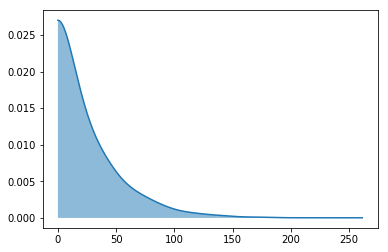

In [74]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), shade=0.5);

In [75]:
with model:
    λ1 = group1_std ** -2
    λ2 = group2_std ** -2

    group1 = pm.StudentT("drug", nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT("placebo", nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [76]:
with model:
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2)
    )

In [77]:
with model:
    trace = pm.sample(10000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:20<00:00, 2295.26draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe08880db70>,
      dtype=object)

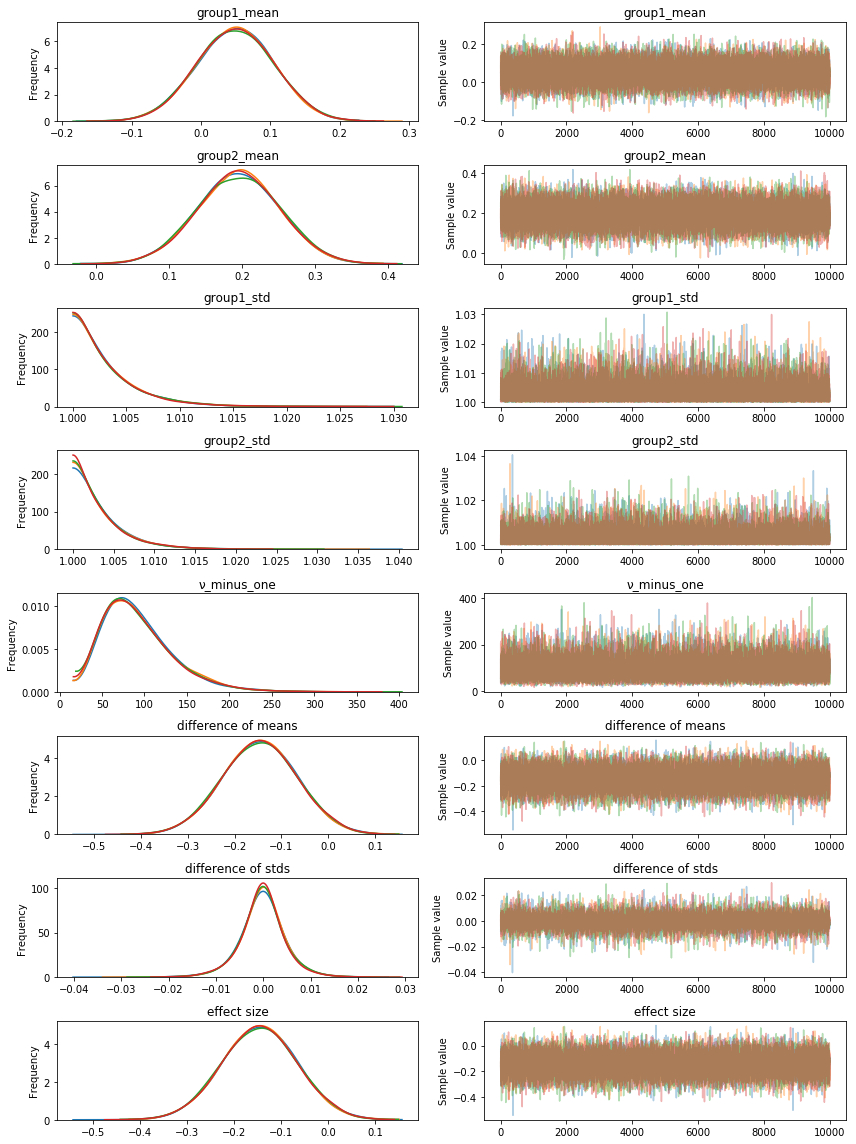

In [78]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0cc07f0f0>,
      dtype=object)

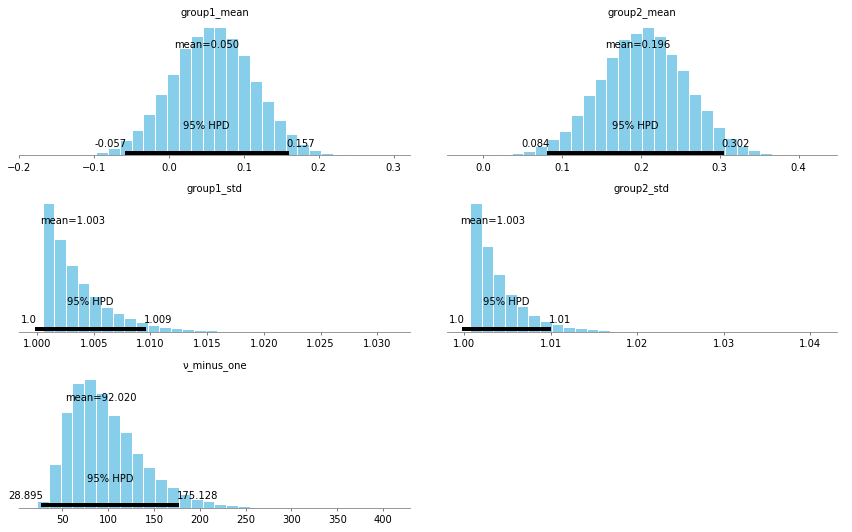

In [79]:
pm.plot_posterior(
    trace,
    varnames=["group1_mean", "group2_mean", "group1_std", "group2_std", "ν_minus_one"],
    color="#87ceeb",
)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe08d5119e8>,
      dtype=object)

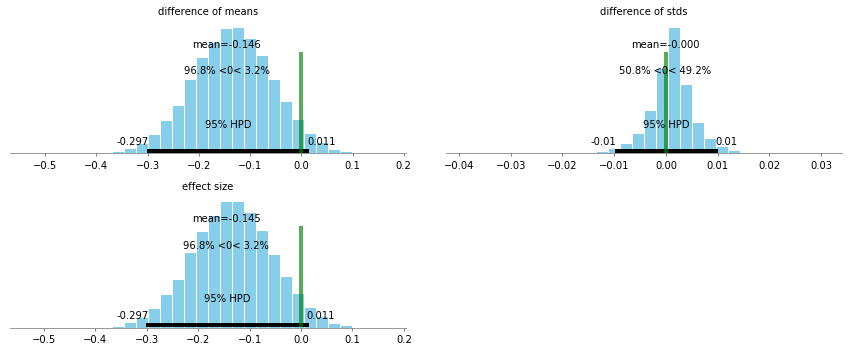

In [80]:
pm.plot_posterior(
    trace,
    varnames=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
)

GridSpec(1, 2, width_ratios=[3, 1])

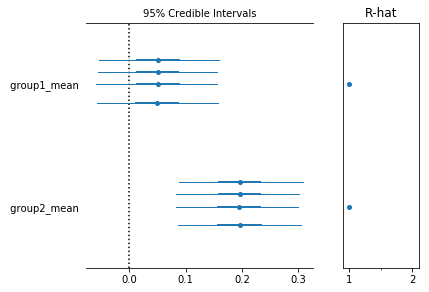

In [81]:
pm.forestplot(trace, varnames=["group1_mean", "group2_mean"])

GridSpec(1, 2, width_ratios=[3, 1])

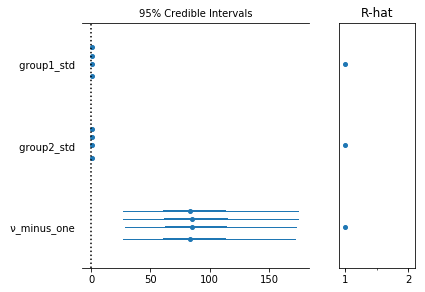

In [82]:
pm.forestplot(trace, varnames=["group1_std", "group2_std", "ν_minus_one"])

In [83]:
pm.summary(trace, varnames=["difference of means", "difference of stds", "effect size"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference of means,-0.145698,0.078729,0.000358,-0.296936,0.011394,36650.292199,0.999965
difference of stds,-0.000126,0.004556,0.000022,-0.009537,0.009644,41463.043331,1.000030
effect size,-0.145232,0.078477,0.000357,-0.296668,0.010749,36664.588537,0.999965


### Non-parametric stats

In [88]:
from sklearn.impute import SimpleImputer
import spm1d

ALPHA = 0.05 / (12 * 3)
N_ITER = 10000
p_value = {}

for imethod in combinations(set(df_comp["method"].unique()), 2):
    print(f"{imethod[0].upper()} vs. {imethod[1].upper()}")
    p_value[imethod] = {}
    for imuscle in MUSCLES:

        a = df_comp.query(f'muscle == "{imuscle}" & method == "{imethod[0]}"')[
            "mape"
        ].values.reshape(-1, 1)
        b = df_comp.query(f'muscle == "{imuscle}" & method == "{imethod[1]}"')[
            "mape"
        ].values.reshape(-1, 1)

        a = SimpleImputer(strategy="median").fit_transform(a)
        b = SimpleImputer(strategy="median").fit_transform(b)

        ttest = spm1d.stats.nonparam.ttest_paired(a.ravel(), b.ravel())
        ttesti = ttest.inference(alpha=ALPHA, iterations=N_ITER, two_tailed=True)

        if ttesti.h0reject:
            direction = ">" if a.mean() > b.mean() else "<"
            string = f"{imethod[0]} {direction} {imethod[1]}"
            p_value[imethod][imuscle] = ttesti.p
        else:
            string = "no differences"
            p_value[imethod][imuscle] = np.nan

        print(f"\t{imuscle}: {string}")

B-4 vs. P-3
	upper trapezius: B-4 > P-3
	middle trapezius: no differences
	lower trapezius: no differences
	anterior deltoid: no differences
	middle deltoid: B-4 > P-3
	posterior deltoid: B-4 > P-3
	pectoralis major: no differences
	serratus anterior: no differences
	latissimus dorsi: no differences
	supraspinatus: no differences
	infraspinatus: no differences
	subscapularis: no differences
B-4 vs. DM-14
	upper trapezius: B-4 > DM-14
	middle trapezius: B-4 > DM-14
	lower trapezius: B-4 > DM-14
	anterior deltoid: no differences
	middle deltoid: B-4 > DM-14
	posterior deltoid: B-4 > DM-14
	pectoralis major: B-4 > DM-14
	serratus anterior: B-4 > DM-14
	latissimus dorsi: B-4 > DM-14
	supraspinatus: B-4 > DM-14
	infraspinatus: no differences
	subscapularis: B-4 > DM-14
P-3 vs. DM-14
	upper trapezius: P-3 > DM-14
	middle trapezius: P-3 > DM-14
	lower trapezius: P-3 > DM-14
	anterior deltoid: no differences
	middle deltoid: no differences
	posterior deltoid: P-3 > DM-14
	pectoralis major: P-3

In [89]:
p = pd.DataFrame(p_value).T.reset_index()
p = (
    p.set_index(p["level_0"] + " vs " + p["level_1"])
    .drop(["level_0", "level_1"], axis=1)
    .T
)
p

,B-4 vs P-3,B-4 vs DM-14,P-3 vs DM-14
anterior deltoid,NaN,NaN,NaN
infraspinatus,NaN,NaN,NaN
latissimus dorsi,NaN,0.0001,0.0001
lower trapezius,NaN,0.0001,0.0001
middle deltoid,0.0002,0.0001,NaN
middle trapezius,NaN,0.0001,0.0001
pectoralis major,NaN,0.0001,0.0001
posterior deltoid,0.0001,0.0001,0.0001
serratus anterior,NaN,0.0002,NaN
subscapularis,NaN,0.0002,NaN


In [90]:
pd.cut(
    p.stack(),
    bins=[-np.inf, 0.0001, 0.001, 0.01, 0.05, np.inf],
    labels=["****", "***", "**", "*", "ns"],
).unstack()

,B-4 vs P-3,B-4 vs DM-14,P-3 vs DM-14
latissimus dorsi,NaN,****,****
lower trapezius,NaN,****,****
middle deltoid,***,****,NaN
middle trapezius,NaN,****,****
pectoralis major,NaN,****,****
posterior deltoid,****,****,****
serratus anterior,NaN,***,NaN
subscapularis,NaN,***,NaN
supraspinatus,NaN,****,NaN
upper trapezius,***,****,***
